In [2]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"kth7025","key":"e6572a04ec70175a19be9b50b4b5524b"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json
# 본인이 참가한 모든 대회 보기 
!kaggle competitions list
!kaggle competitions download -c 2019-1st-ml-month-with-kakr

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                   2030-07-01 23:59:00  Getting Started     Prizes         82           False  
gan-getting-started                            2030-07-01 23:59:00  Getting Started     Prizes        174           False  
tpu-getting-started                            2030-06-03 23:59:00  Getting Started  Knowledge        403           False  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       2698           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      21391           False  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge       5406           False  
connectx

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
IDtest = test['PassengerId']

In [6]:
#Outlier detection

def detect_outliers(df, n, features):


  outlier_indices=[]

  #각 feature를 기준으로 아웃라이어 판단
  for col in features:
    Q1 = np.percentile(df[col], 25)
    Q3 = np.percentile(df[col], 75)
    IQR = Q3 - Q1
    
    outlier_step = 1.5 * IQR

    outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index

    outlier_indices.extend(outlier_list_col)
  
  outlier_indices = Counter(outlier_indices)
  multiple_outliers = list( k for k, v in outlier_indices.items() if v>n)

  return multiple_outliers

Outliers_to_drop = detect_outliers(train, 2, ['Age', 'SibSp', 'Parch', 'Fare'])

In [7]:
train.loc[Outliers_to_drop] # Show the outliers rows

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [8]:
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

In [9]:
train_len = len(train)
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

In [10]:
dataset = dataset.fillna(np.nan)
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

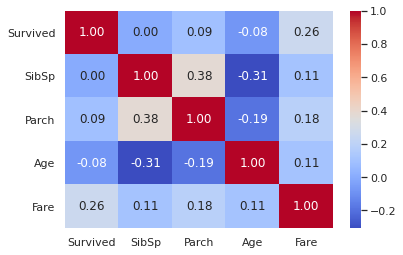

In [11]:
g = sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

correlation 값을 통해 각 feature가 다른 feature와의 연관성을 수치로 판단

Fare가 Survived에 비교적 큰 영향을 미침을 알 수 있음

그렇다고 correlation 수치가 적은 feature를 무시하면 안됨

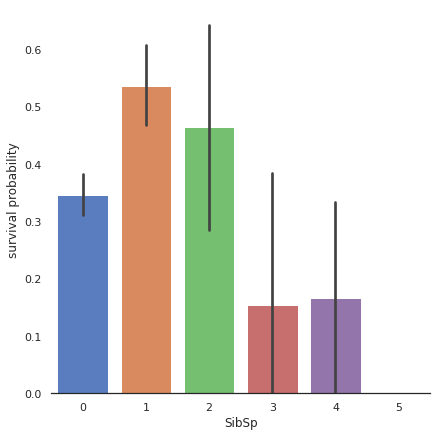

In [12]:
g = sns.catplot(x="SibSp",y="Survived",data=train,kind="bar", height = 6 , palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

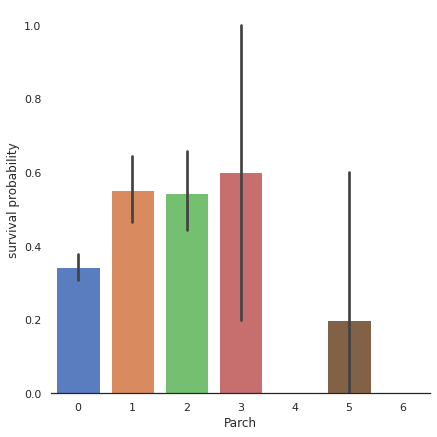

In [13]:
g  = sns.catplot(x="Parch",y="Survived",data=train,kind="bar", height = 6 , palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

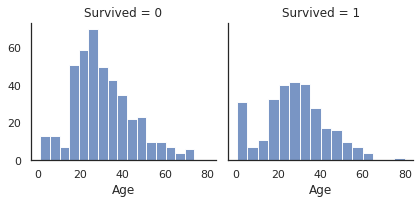

In [14]:
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.histplot, "Age")

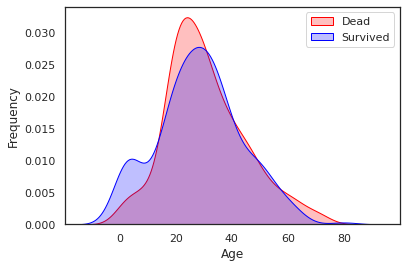

In [15]:
g= sns.kdeplot(train['Age'][(train['Survived']==0) & (train['Age'].notnull())], color ='Red', shade = True)
g = sns.kdeplot(train['Age'][(train['Survived']==1) & (train['Age'].notnull())], ax=g, color='Blue', shade=True)
g.set_xlabel('Age')
g.set_ylabel('Frequency')
g = g.legend(['Dead', 'Survived'])

In [16]:
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

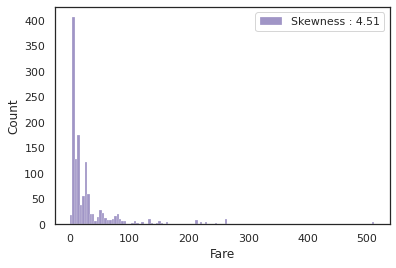

In [17]:
g = sns.histplot(dataset["Fare"], color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

In [18]:
dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

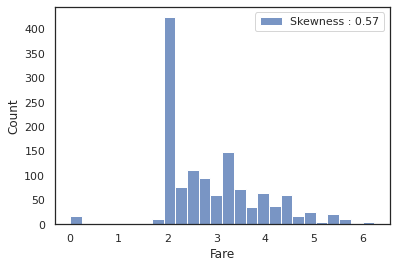

In [19]:
g = sns.histplot(dataset["Fare"], color="b", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

In [20]:
dataset["Embarked"].isnull().sum()

2

In [21]:
dataset["Embarked"] = dataset["Embarked"].fillna("S")

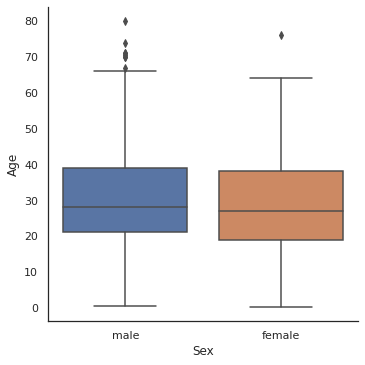

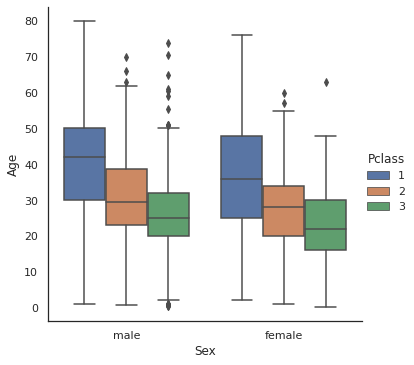

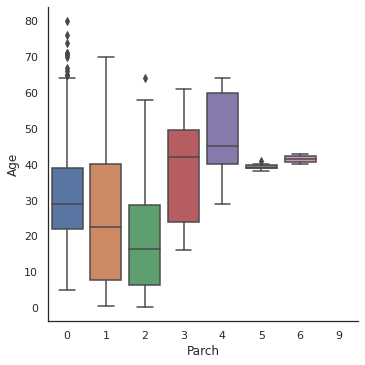

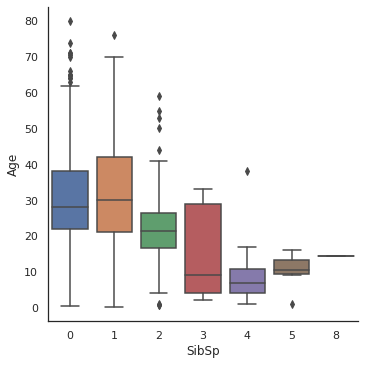

In [22]:
g = sns.catplot(y="Age",x="Sex",data=dataset,kind="box")
g = sns.catplot(y="Age",x="Sex",hue="Pclass", data=dataset,kind="box")
g = sns.catplot(y="Age",x="Parch", data=dataset,kind="box")
g = sns.catplot(y="Age",x="SibSp", data=dataset,kind="box")

In [23]:
dataset["Sex"] = dataset["Sex"].map({"male": 0, "female":1})

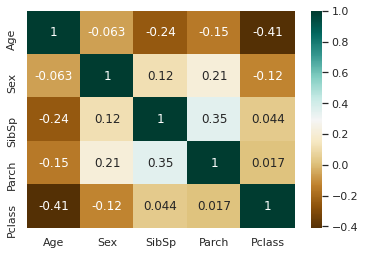

In [24]:
g = sns.heatmap(dataset[["Age","Sex","SibSp","Parch","Pclass"]].corr(),cmap="BrBG",annot=True)

In [25]:
index_NaN_age = list(dataset['Age'][dataset['Age'].isnull()].index)

In [26]:
age_med = dataset['Age'].median()

for i in index_NaN_age:
  age_pred = dataset["Age"][((dataset['SibSp'] == dataset.iloc[i]["SibSp"]) & (dataset['Parch'] == dataset.iloc[i]["Parch"]) & (dataset['Pclass'] == dataset.iloc[i]["Pclass"]))].median()
  if not np.isnan(age_pred):
    dataset['Age'].iloc[i] = age_pred
  else:
    dataset['Age'].iloc[i] = age_med

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

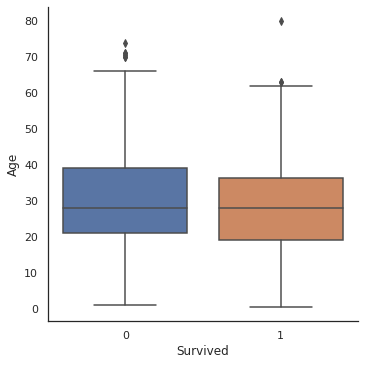

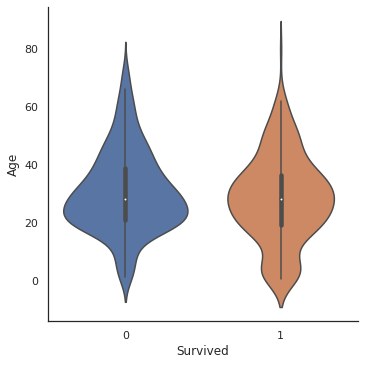

In [27]:
g = sns.catplot(x="Survived", y = "Age",data = train, kind="box")
g = sns.catplot(x="Survived", y = "Age",data = train, kind="violin")

In [28]:
dataset['Age'].isnull().sum()

0

In [29]:
dataset_title = [i.split(',')[1].split('.')[0].strip() for i in dataset['Name']]
dataset['Title'] = pd.Series(dataset_title)
dataset['Title'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

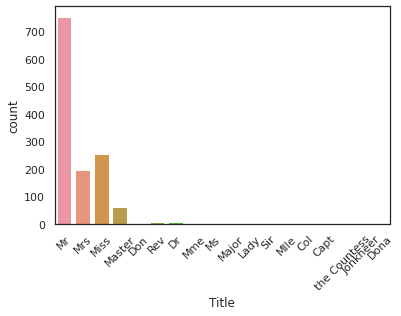

In [30]:
g = sns.countplot(x="Title",data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45) 

In [31]:
# Convert to categorical values Title 
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


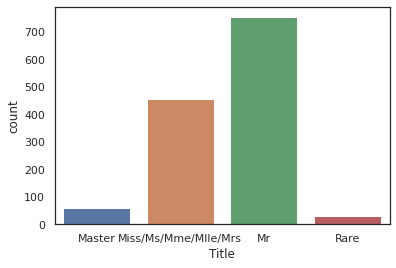

In [32]:
g = sns.countplot(dataset["Title"])
g = g.set_xticklabels(["Master","Miss/Ms/Mme/Mlle/Mrs","Mr","Rare"])

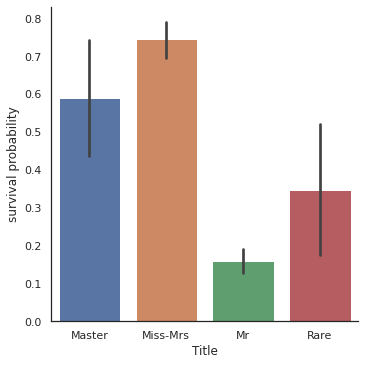

In [33]:
g = sns.catplot(x="Title",y="Survived",data=dataset,kind="bar")
g = g.set_xticklabels(["Master","Miss-Mrs","Mr","Rare"])
g = g.set_ylabels("survival probability")

In [34]:
dataset.drop(labels = ["Name"], axis = 1, inplace = True)

In [35]:
# Create a family size descriptor from SibSp and Parch
dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"] + 1

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


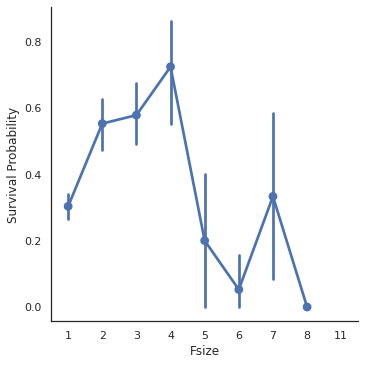

In [36]:
g = sns.factorplot(x="Fsize",y="Survived",data = dataset)
g = g.set_ylabels("Survival Probability")

In [37]:
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if  2 <= s <= 3  else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if s == 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)

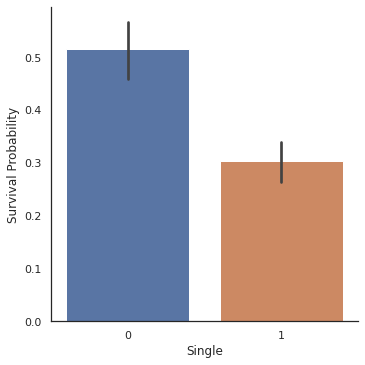

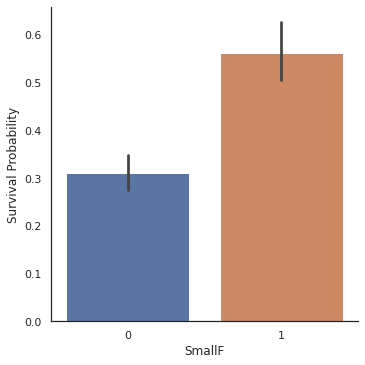

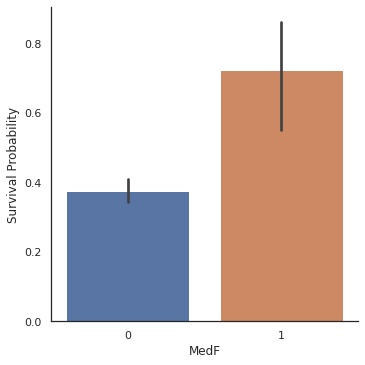

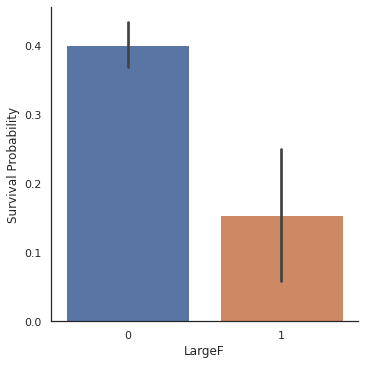

In [38]:
g = sns.catplot(x="Single",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.catplot(x="SmallF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.catplot(x="MedF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.catplot(x="LargeF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")

In [39]:
dataset = pd.get_dummies(dataset, columns = ["Title"])
dataset = pd.get_dummies(dataset, columns = ["Embarked"], prefix="Em")

In [40]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Fsize,Single,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,2,0,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,2,0,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,1,1,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,2,0,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,1,1,0,0,0,0,0,1,0,0,0,1


In [41]:
dataset['Cabin'].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [42]:
dataset["Cabin"][dataset["Cabin"].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [43]:
dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin'] ])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


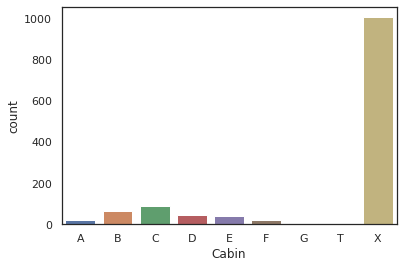

In [44]:
g = sns.countplot(dataset["Cabin"],order=['A','B','C','D','E','F','G','T','X'])

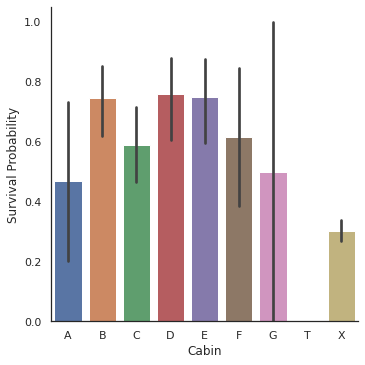

In [45]:
g = sns.catplot(y="Survived",x="Cabin",data=dataset,kind="bar",order=['A','B','C','D','E','F','G','T','X'])
g = g.set_ylabels("Survival Probability")

In [46]:
dataset = pd.get_dummies(dataset, columns = ["Cabin"],prefix="Cabin")

In [47]:
dataset["Ticket"].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [48]:
Ticket = []
for i in list(dataset.Ticket):
  if not i.isdigit():
    Ticket.append(i.replace('.','').replace('/','').strip().split(' ')[0])
  else:
    Ticket.append('X')
dataset['Ticket'] = Ticket
dataset['Ticket'].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [49]:
dataset = pd.get_dummies(dataset, columns = ["Ticket"], prefix="T")

In [50]:
dataset["Pclass"] = dataset["Pclass"].astype("category")
dataset = pd.get_dummies(dataset, columns = ["Pclass"],prefix="Pc")

In [51]:
dataset.drop(labels = ["PassengerId"], axis = 1, inplace = True)

In [52]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X,T_A,T_A4,T_A5,T_AQ3,T_AQ4,T_AS,T_C,T_CA,T_CASOTON,T_FC,T_FCC,T_Fa,T_LINE,T_LP,T_PC,T_PP,T_PPP,T_SC,T_SCA3,T_SCA4,T_SCAH,T_SCOW,T_SCPARIS,T_SCParis,T_SOC,T_SOP,T_SOPP,T_SOTONO2,T_SOTONOQ,T_SP,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1


In [53]:
train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=["Survived"],axis = 1,inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [54]:
train["Survived"] = train["Survived"].astype(int)

Y_train = train["Survived"]

X_train = train.drop(labels = ["Survived"],axis = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [55]:
train.isnull().sum()

Survived    0
Sex         0
Age         0
SibSp       0
Parch       0
           ..
T_WEP       0
T_X         0
Pc_1        0
Pc_2        0
Pc_3        0
Length: 67, dtype: int64

In [56]:
#kfold를 통해 best model 찾기

kfold = StratifiedKFold(n_splits=10)

In [57]:
random_state=2
classifiers=[]
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

In [58]:
cv_results = []
for classifier in classifiers :
  cv_results.append(cross_val_score(classifier, X_train, y=Y_train, scoring = 'accuracy', cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
  cv_means.append(cv_result.mean())
  cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


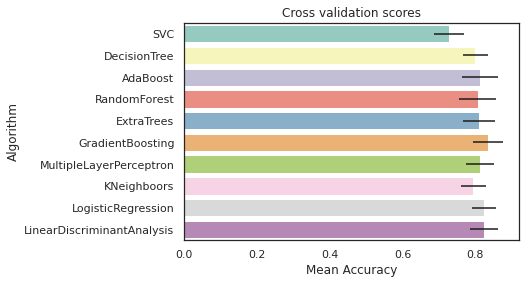

In [59]:
g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [ ]:
# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsadaDTC.fit(X_train,Y_train)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  56 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done 656 tasks      | elapsed:    9.9s
[Parallel(n_jobs=4)]: Done 1120 out of 1120 | elapsed:   15.2s finished


In [ ]:
gsadaDTC.best_score_

0.8241317671092953

In [ ]:
#ExtraTrees 
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsExtC.fit(X_train,Y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   43.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  2.2min finished


0.8388406537282942

In [ ]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   13.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   47.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  2.5min finished


0.8377170582226763

In [ ]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   27.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   59.8s
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:  1.6min finished


0.8286006128702759

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
  #learning curve
  plt.figure()
  plt.title(title)
  if ylim is not None:
    plt.ylim(*ylim)
  plt.xlabel('Training examples')
  plt.ylabel('Score')
  train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
  train_scores_mean = np.mean(train_scores, axis = 1)
  train_scores_std = np.std(train_scores, axis = 1)
  test_scores_mean = np.mean(test_scores, axis = 1)
  test_scores_std = np.std(test_scores, axis = 1)
  plt.grid()

  plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha = 0.1, color = 'r')
  plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')

  plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
  plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')

  plt.legend(loc = 'best')
  return plt

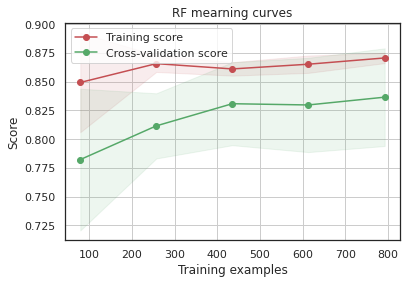

In [ ]:
g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,Y_train,cv=kfold)

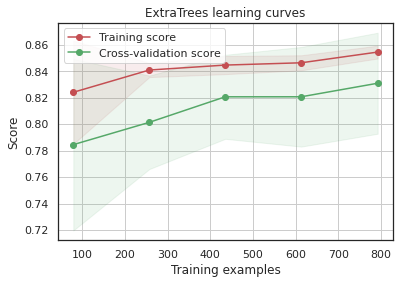

In [ ]:
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)

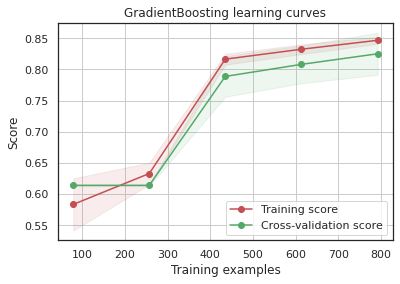

In [ ]:
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)

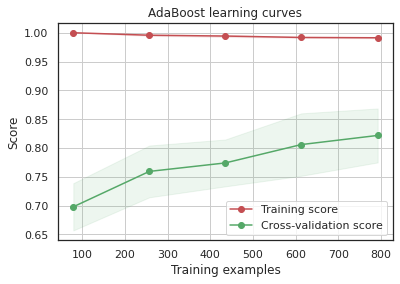

In [ ]:
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)

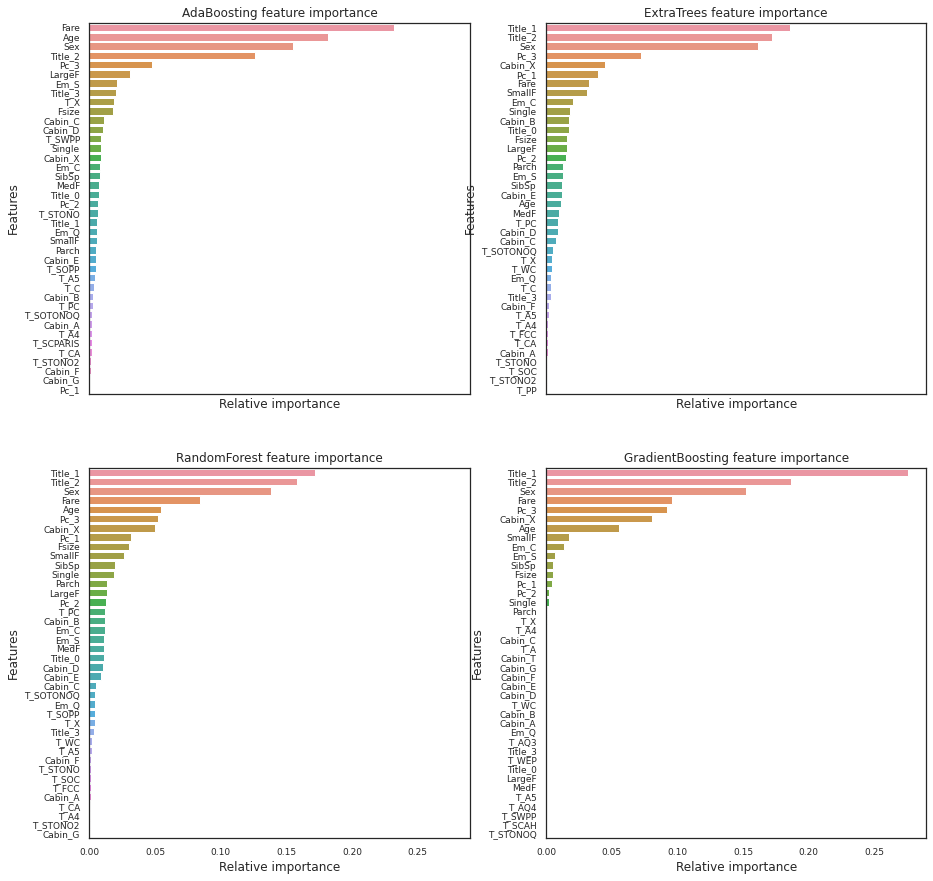

In [ ]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex = 'all', figsize = (15, 15))

names_classifiers = [('AdaBoosting', ada_best), ('ExtraTrees', ExtC_best), ("RandomForest", RFC_best),('GradientBoosting', GBC_best)]

nclassifier = 0

for row in range(nrows):
  for col in range(ncols):
    name = names_classifiers[nclassifier][0]
    classifier = names_classifiers[nclassifier][1]
    indices = np.argsort(classifier.feature_importances_)[::-1][:40]
    g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40], orient='h', ax = axes[row][col])
    g.set_xlabel("Relative importance",fontsize=12)
    g.set_ylabel("Features",fontsize=12)
    g.tick_params(labelsize=9)
    g.set_title(name + " feature importance")
    nclassifier += 1

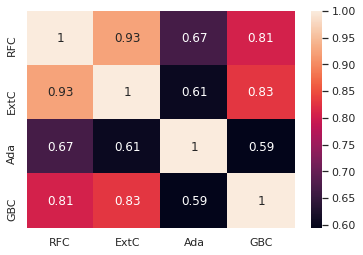

In [ ]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")


# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)

In [ ]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, Y_train)